In [20]:
import os
import sys

os.environ["JAVA_HOME"] = "JDK 8/Contents/Home"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
import csv

In [22]:
spark = SparkSession\
    .builder\
    .appName('AQ_Project')\
    .getOrCreate()

**Exercise 1: Retrieve and test the AQ file for errors**

In [23]:
url = "https://maps2.bristol.gov.uk/server2/rest/services/ext/air_quality/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"

try:
    check = requests.get(url)
    data = check.json()  #changes the data to JSON format
    print(data)  #prints data to test it's ok
except Exception as e:
    print(f"Error retrieving the data: {e}")

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'id': 1, 'geometry': {'type': 'Point', 'coordinates': [-2.6277488032062446, 51.407745517999835]}, 'properties': {'OBJECTID': 1, 'siteNo': '1', 'location': 'Withywood School', 'SiteID': 1, 'Easting': 356434, 'Northing': 167823, 'Current_': 'No', 'pollutants': 'BTX NO2', 'InstrumentID': 1, 'Exposure': 'No', 'tube_kerb': 0, 'rec_kerb': 0, 'comments': '', 'AQMA': 'Yes', 'Detailed_Location': '', 'Tube_Height': None, 'Elevation': None, 'Grid_ID': None, 'LocationClass': 'Urban Traffic', 'LAQM_Locationclass': 'Roadside', 'Survey': 'Other (DT)', 'RouteID': None, 'RouteSequenceID': None, 'Description': '', 'DateStart': None, 'DateEnd': None, 'Colocated': None, 'Duplicate_Triplicate': '', 'obstruction_m': None, 'obstruction_lt': 'No', 'inlet_flow_clear': 'No', 'junction_m': None}}, {'type': 'Feature', 'id': 2, 'geometry': {'type': 'Point', 'coordinates': [-2.5968139474821794, 51.454556566902696]}, 'properties': {'OBJECTID': 2, 'siteNo

**Exercise 2: Normalisation**

As we want to scale values from 0 and 1 we want to use min max normalisation

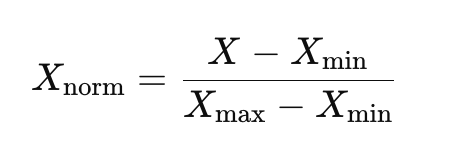

In [24]:
def normalisation(num, mini, maxim):
    '''Normnalisation using min max scaling.'''
    if maxim == mini: #checks for equals between min and max
        return 0.5
    return (num - mini) / (maxim - mini) #calculates the min max 

    

In [25]:
print(normalisation(100, 0 ,50)) # this tests to see if it works

2.0


**Exercise 3: Prepare the data for loading**

In [26]:
path = "/Users/tomdursley/Downloads/Air_quality_monitors.geojson" #defined the path of where the file is located
Air_sparkdf = spark.read.option("multiline", "true").json(path) #read the file properly so it doesn't show corrupted columns

Air_sparkdf.show()  #printed off the file to see what it looks like 


+--------------------+--------------------+--------------------+-----------------+
|                 crs|            features|                name|             type|
+--------------------+--------------------+--------------------+-----------------+
|{{urn:ogc:def:crs...|[{{[-2.6290685140...|Air_quality_monitors|FeatureCollection|
+--------------------+--------------------+--------------------+-----------------+



In [27]:
Air_sparkdf.selectExpr("features").show(truncate=False) #test to see if the data is in one row

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
Rowfix_df = Air_sparkdf.selectExpr("inline(features)") #unpack the data and find the correct fields
Rowfix_df.show(5, truncate=False) #present the new rows

+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|geometry                                         |properties                                                                                                                                                                                                                                                                                                 |type   |
+-------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
Rowfix_df.printSchema()

root
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- AQMA: string (nullable = true)
 |    |-- Colocated: long (nullable = true)
 |    |-- Current_: string (nullable = true)
 |    |-- DateEnd: string (nullable = true)
 |    |-- DateStart: string (nullable = true)
 |    |-- Description: string (nullable = true)
 |    |-- Detailed_Location: string (nullable = true)
 |    |-- Duplicate_Triplicate: string (nullable = true)
 |    |-- Easting: long (nullable = true)
 |    |-- Elevation: double (nullable = true)
 |    |-- Exposure: string (nullable = true)
 |    |-- Grid_ID: long (nullable = true)
 |    |-- InstrumentID: long (nullable = true)
 |    |-- LAQM_Locationclass: string (nullable = true)
 |    |-- LocationClass: string (nullable = true)
 |    |-- Northing: long (nullable = true)
 |    |-- OBJECTID: lon

In [30]:
StructuredAir_df = Rowfix_df.select( #find and change the names of the columns you want
    col("properties.OBJECTID").alias("ID"), #select the group (properties) then the column you want
    col("properties.location").alias("Location"),
    col("properties.Locationclass").alias("Location_type"),
    col("geometry.coordinates")[1].alias("Latitude"),  #positive numbers
    col("geometry.coordinates")[0].alias("Longitude") #negative numbers
)

StructuredAir_df.show()

+---+-----------------+----------------+------------------+------------------+
| ID|         Location|   Location_type|          Latitude|         Longitude|
+---+-----------------+----------------+------------------+------------------+
|  1| Withywood School|   Urban Traffic| 51.40822835721291|-2.629068514063199|
|  2|   Colston Avenue|   Urban Traffic| 51.45503494834262|-2.598137704102741|
|  3|    Blackboy Hill|   Urban Traffic|51.469682294439075|-2.615317505038476|
|  4|      Three Lamps|   Urban Traffic| 51.44468970951661|-2.579659103227444|
|  5|Bedminster Parade|   Urban Traffic| 51.44329165406191|-2.596618469982965|
|  6|      Church Road|   Urban Traffic|51.458836838013994|-2.560292603143524|
|  7|  St. Andrew's Rd|   Urban Traffic| 51.50158127753037| -2.69846376771532|
|  8|    Higham Street|Urban Background| 51.44516140127984|-2.580629034817171|
|  9|           B.R.I.|   Urban Traffic|  51.4594298263055|-2.596741554985489|
| 10|        Bath Road|   Urban Traffic| 51.44099689

In [31]:
null_count = StructuredAir_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in StructuredAir_df.columns])  #find the null values in the data set

print("the number of null values is: ")

null_count.show()

the number of null values is: 
+---+--------+-------------+--------+---------+
| ID|Location|Location_type|Latitude|Longitude|
+---+--------+-------------+--------+---------+
|  0|       0|            0|       0|        0|
+---+--------+-------------+--------+---------+



In [32]:
lat_min = StructuredAir_df.select(min("Latitude")).collect()[0][0] #defined the minimum 
lat_max = StructuredAir_df.select(max("Latitude")).collect()[0][0] #defined the maximum

In [33]:
normalisation_udf = udf(lambda lat: normalisation(lat, lat_min, lat_max), DoubleType()) 
#converted my fucntuon to udf and made sure the column is in DoubleType format

In [34]:
final_air_df = StructuredAir_df.withColumn("Latitude_normalised", normalisation_udf(col("Latitude"))) #create the new table using my function

final_air_df.show(10)

+---+-----------------+----------------+------------------+------------------+-------------------+
| ID|         Location|   Location_type|          Latitude|         Longitude|Latitude_normalised|
+---+-----------------+----------------+------------------+------------------+-------------------+
|  1| Withywood School|   Urban Traffic| 51.40822835721291|-2.629068514063199|0.09093774496733553|
|  2|   Colston Avenue|   Urban Traffic| 51.45503494834262|-2.598137704102741|0.29381988672233417|
|  3|    Blackboy Hill|   Urban Traffic|51.469682294439075|-2.615317505038476|0.35730848683935723|
|  4|      Three Lamps|   Urban Traffic| 51.44468970951661|-2.579659103227444|0.24897867612932068|
|  5|Bedminster Parade|   Urban Traffic| 51.44329165406191|-2.596618469982965| 0.2429188354509884|
|  6|      Church Road|   Urban Traffic|51.458836838013994|-2.560292603143524|0.31029909404394235|
|  7|  St. Andrew's Rd|   Urban Traffic| 51.50158127753037| -2.69846376771532|0.49557392880316653|
|  8|    H

**Exercise 4: Load data into CSV format**

In [35]:
Air_pandas_df = final_air_df.toPandas() #convert my df to pandasdf

In [36]:
loaded_file = "air_quality_tranformation.csv" #name the file i'm loading locally

with open(loaded_file, "w") as outfile: #write the file
    writer = csv.writer(outfile) #make sure it's csv
    writer.writerow(Air_pandas_df.columns) #make sure the format is right
    writer.writerows(Air_pandas_df.values)